In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dalex as dx

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from catboost import CatBoostClassifier
from matplotlib import style

plt.style.use('dark_background')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['red'])

In [26]:
#loading data
df = pd.read_csv('./BankChurners.csv')
df.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], inplace=True)

#setting y to 0-1 binary variable
df['Attrition_Flag'].mask(df['Attrition_Flag'] == 'Existing Customer', 1, inplace=True)
df['Attrition_Flag'].mask(df['Attrition_Flag'] == 'Attrited Customer', 0, inplace=True)

#defining and splitting variables
X = df.drop(columns=['CLIENTNUM', 'Attrition_Flag'])
y = df['Attrition_Flag']

idx_train, idx_test = train_test_split(X.index, stratify=y, random_state=999)

X_train, X_test = X.loc[idx_train], X.loc[idx_test]
y_train, y_test = y[idx_train], y[idx_test]

#selecting numerical and categorical columns
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X_train.select_dtypes(include='object').columns

In [27]:
scaler = MinMaxScaler(feature_range=(0,1))

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

encoder = OneHotEncoder(sparse_output=False, handle_unknown="error", dtype=float).set_output(transform="pandas")

one_hot_encoded_train = encoder.fit_transform(X_train[categorical_columns])
one_hot_encoded_test = encoder.transform(X_test[categorical_columns])

X_train.drop(columns=categorical_columns, inplace=True)
X_test.drop(columns=categorical_columns, inplace=True)

X_train = pd.concat([X_train, one_hot_encoded_train], axis=1)
X_test = pd.concat([X_test, one_hot_encoded_test], axis=1)

In [28]:
#declaring and building model
model = CatBoostClassifier(verbose=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

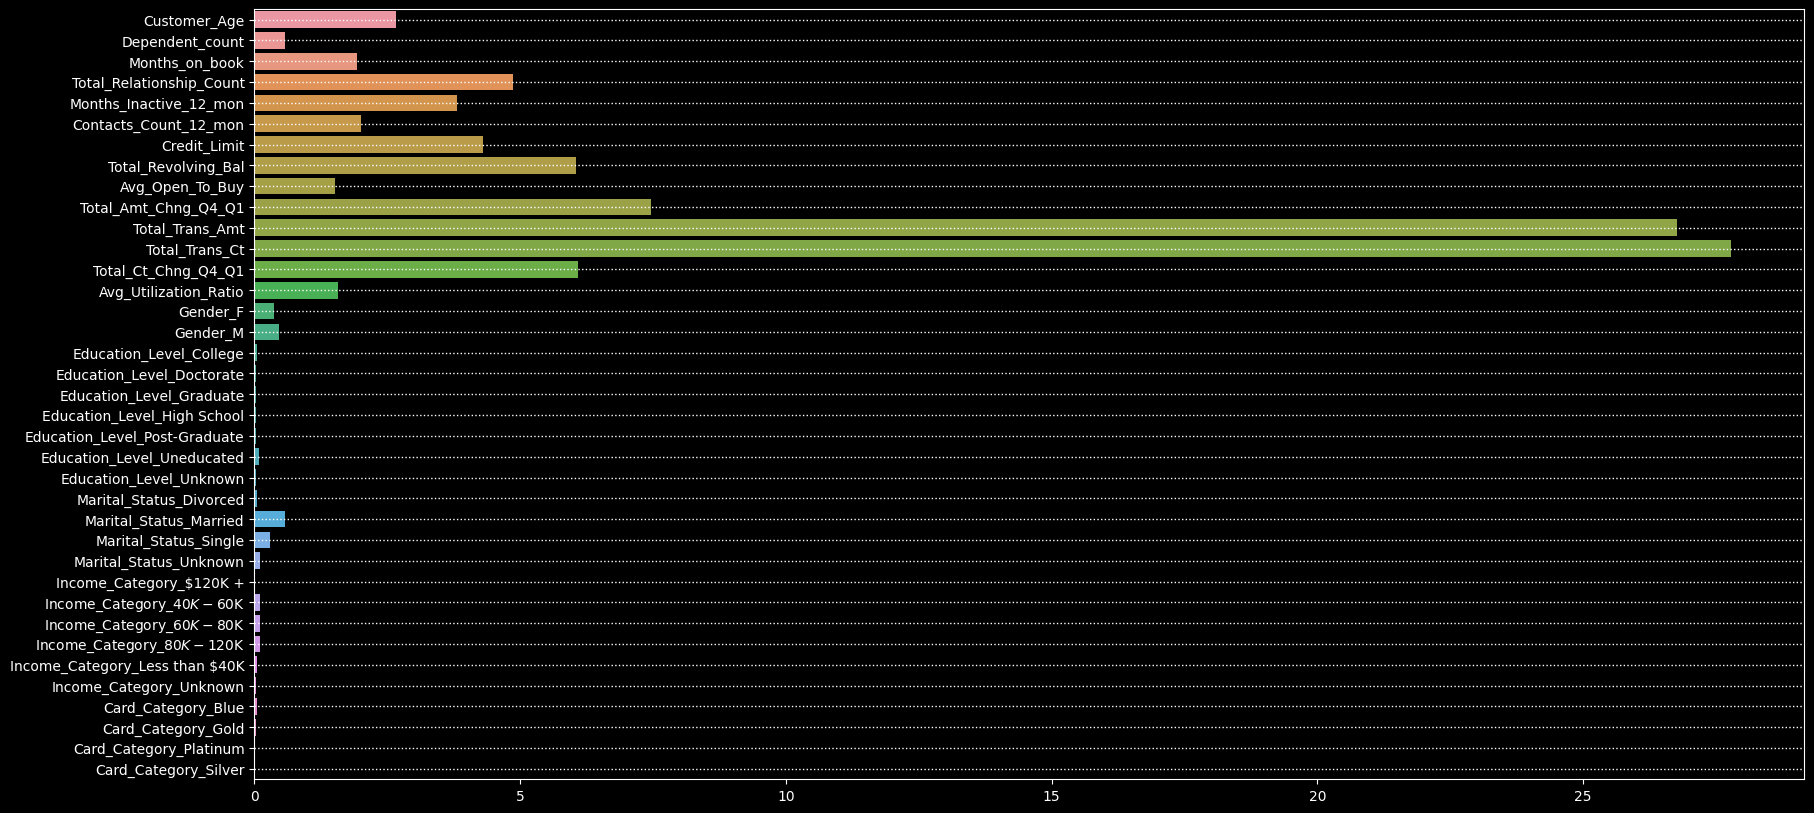

In [29]:
plt.figure(figsize=(20,10))
sns.barplot(x=model.feature_importances_, y=X_train.columns)
plt.grid(axis='y', color='white', linestyle='dotted', lw=1)
plt.show()

In [30]:
roc_auc_score(y_pred, y_test)

0.9703712216986553